In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

##### нестационарный ряд

In [7]:
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")


In [8]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [9]:
series = boxcox(dowjones_closing["Close"], 0)

In [10]:
series = series[1:] - series[:-1]

##### стационарный ряд

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


D:\Program Files\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


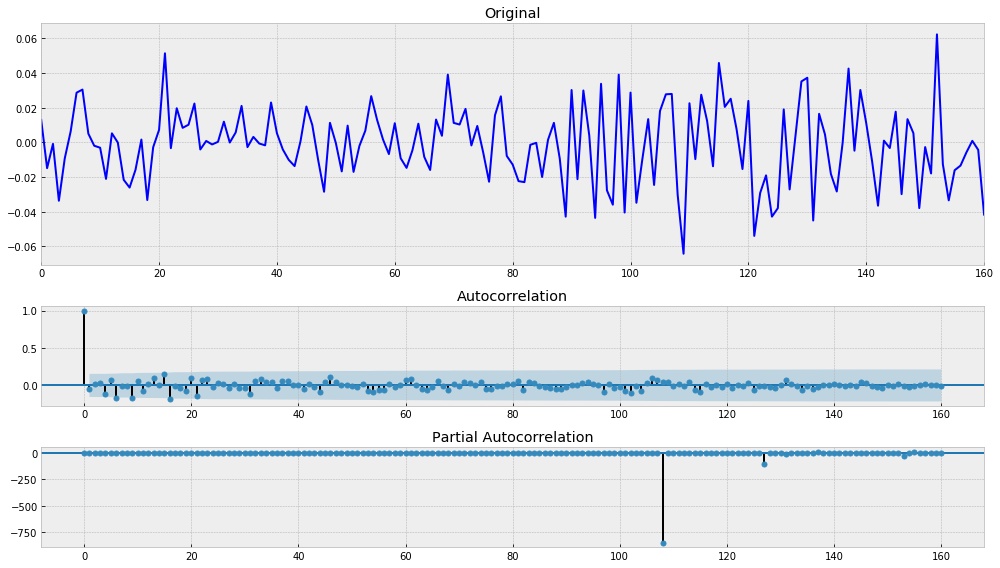

In [11]:
tsplot(series)

#### Скользящее среднее

In [12]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

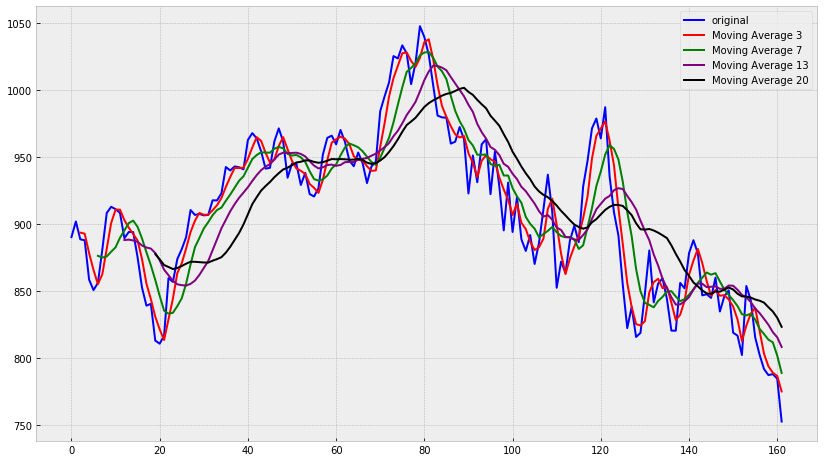

In [13]:
windows = [3,7,13,20]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(dowjones_closing["Close"], color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(dowjones_closing["Close"], windows[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
    plt.legend()

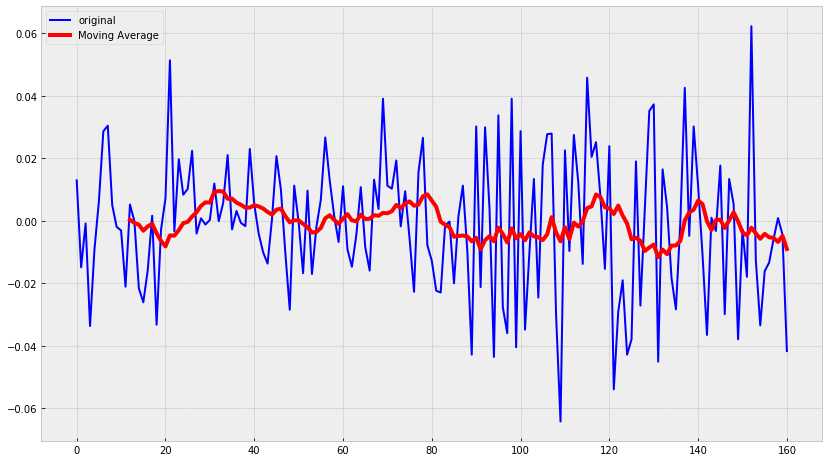

In [14]:
# поквартальный тренд (13 недель)
ser = moving_average(series, 13)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

#### Двойное экспоненциальное сглаживание

In [15]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [16]:
def plot_dema(alpha, beta, series):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

подбираем параметры для нестационарного ряда и проверяем ошибку

In [162]:
mean_squared_error(dowjones_closing["Close"], double_ema(dowjones_closing["Close"],0.983, 0.061 ))

12.422927926290164

сравниваем с ошибкой для скользящего среднего с широной окна =3

In [201]:
window=3
mean_squared_error(dowjones_closing["Close"][window-1:], moving_average(dowjones_closing["Close"], window)[window-1:])

211.30126388889047

подбираем параметры для стационарного ряда и проверяем ошибку

In [193]:
mean_squared_error(series, double_ema(series,0.919, 0.195 ))

2.2608054196090782e-05

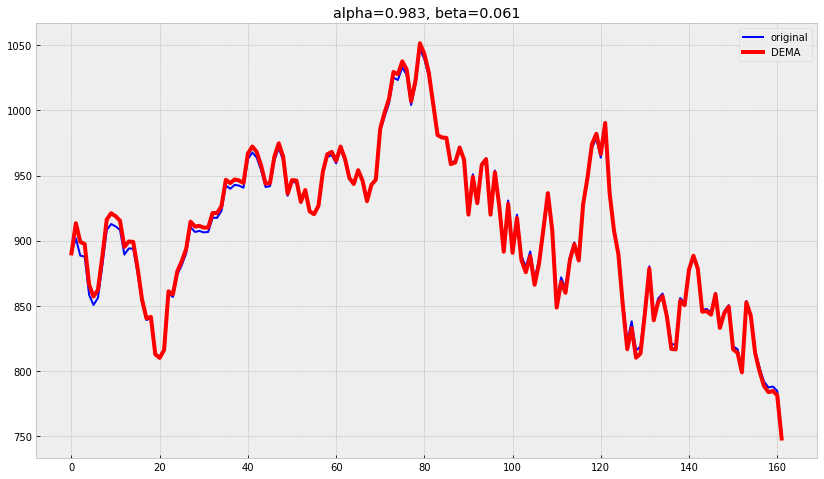

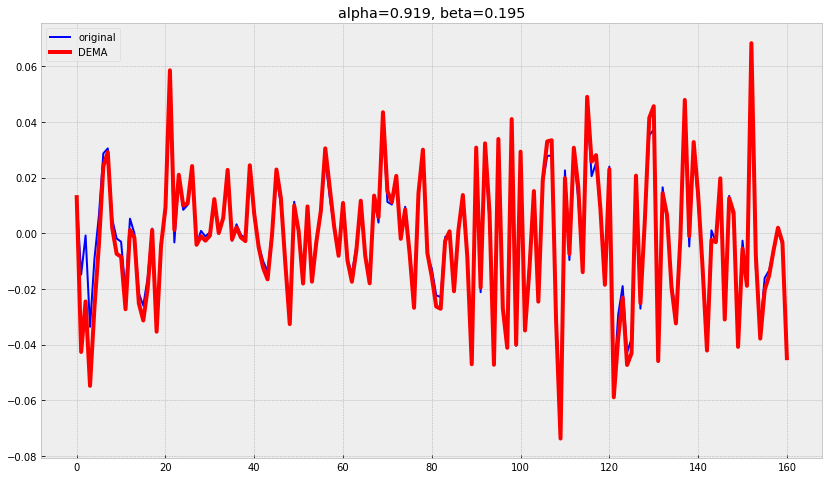

In [194]:
plot_dema(0.983, 0.061, dowjones_closing["Close"])
plot_dema(0.919, 0.195, series)

ряд не обладает сезонностью поэтому применять модель Хольт-Винтерса не имеет смысла